<a href="https://colab.research.google.com/github/thaispatricio9/awari-bookstore/blob/main/book_recommendation_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sistema de Recomendação de Livros com Surprise

## Instalar pacotes

In [2]:
# Instalar a biblioteca Surprise
!pip install surprise

In [1]:
!pip install cdifflib

In [3]:
!pip install streamlit

## Funções

In [4]:
def get_book_id(book_title, metadata):
    
    """
    Gets the book ID for a book title based on the closest match in the metadata dataframe.
    """
    
    existing_titles = list(metadata['Book-Title'].values)
    closest_titles = difflib.get_close_matches(book_title, existing_titles)
    book_id = metadata[metadata['Book-Title'] == closest_titles[0]]['ISBN'].values[0]
    return book_id

def get_book_info(book_id, metadata, rating):
    
    """
    Returns some basic information about a book given the book id and the metadata dataframe.
    """
    
    book_info = metadata[metadata['ISBN'] == book_id][['ISBN', 'Book-Author', 'Book-Title']]
    info = book_info.to_dict(orient='records')[0]
    info["rating"]=rating
    return info

def predict_review(user_id, book_title, model, metadata):
    
    """
    Predicts the review (on a scale of 1-5) that a user would assign to a specific book. 
    """
    
    book_id = get_book_id(book_title, metadata)
    review_prediction = model.predict(uid=user_id, iid=book_id)
    return review_prediction.est

def generate_recommendation(user_id, model, metadata, thresh=4):
    
    """
    Generates a book recommendation for a user based on a rating threshold. Only
    books with a predicted rating at or above the threshold will be recommended
    """
    read_books = list(metadata[metadata['User-ID'] == user_id]['Book-Title'].unique())
    book_titles = list(metadata['Book-Title'].values)
    random.shuffle(book_titles)

    recommendations = []
    book = 1
    for book_title in book_titles:
      if book_title not in read_books:  
        rating = predict_review(user_id, book_title, model, metadata)
        if rating >= thresh:
          book_id = get_book_id(book_title, metadata)
          recommendations.append(get_book_info(book_id, metadata, rating))
          if book >= 3:
            return recommendations
          book += 1
    return recommendation

## Importar dados e bilbiotecas

In [5]:
# Importar bilbiotecas
import pandas as pd
from surprise import Dataset
from surprise import Reader
from surprise import SVD
from surprise.model_selection import cross_validate
import difflib
import random
import streamlit as st
from PIL import Image
import urllib.request
import matplotlib.pyplot as plt
import matplotlib.image as img
import io

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
dir = "/content/drive/MyDrive/Awari/Projeto/"

In [8]:
# Ler os aquivos como dataframes
books = pd.read_csv(f'{dir}Books.csv')
users = pd.read_csv(f'{dir}Users.csv')
ratings = pd.read_csv(f'{dir}Ratings.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3170: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Tratamento dos dados

Unir os dataframes e limpar os dados deixando apenas as colunas necessárias

In [ ]:
# Merge files
data = ratings.merge(books, on = 'ISBN').merge(users, on='User-ID')

In [ ]:
data.head()

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,Location,Age
0,276725,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,"tyler, texas, usa",NaN
1,2313,034545104X,5,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,"cincinnati, ohio, usa",23.0
2,2313,0812533550,9,Ender's Game (Ender Wiggins Saga (Paperback)),Orson Scott Card,1986,Tor Books,http://images.amazon.com/images/P/0812533550.0...,http://images.amazon.com/images/P/0812533550.0...,http://images.amazon.com/images/P/0812533550.0...,"cincinnati, ohio, usa",23.0
3,2313,0679745580,8,In Cold Blood (Vintage International),TRUMAN CAPOTE,1994,Vintage,http://images.amazon.com/images/P/0679745580.0...,http://images.amazon.com/images/P/0679745580.0...,http://images.amazon.com/images/P/0679745580.0...,"cincinnati, ohio, usa",23.0
4,2313,0060173289,9,Divine Secrets of the Ya-Ya Sisterhood : A Novel,Rebecca Wells,1996,HarperCollins,http://images.amazon.com/images/P/0060173289.0...,http://images.amazon.com/images/P/0060173289.0...,http://images.amazon.com/images/P/0060173289.0...,"cincinnati, ohio, usa",23.0


In [ ]:
# Filtrar linhas que contenham uma nota válida (1 a 10)
data = data[data['Book-Rating']>0]

In [ ]:
data.groupby(['User-ID'])['Book-Rating'].count().sort_values(ascending=False)

User-ID
11676     6943
98391     5691
189835    1899
153662    1845
23902     1180
          ... 
141645       1
141641       1
141640       1
141631       1
138845       1
Name: Book-Rating, Length: 68091, dtype: int64

## Modelo
Construção do modelo usando o método SVD da biblioteca Surprise

In [ ]:
reader = Reader(rating_scale=(1, 10))
df = Dataset.load_from_df(data[['User-ID', 'ISBN', 'Book-Rating']], reader)

In [ ]:
svd = SVD() # Método de decomposição matricial
cross_validate(svd, df, measures = ['RMSE', 'MSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.6274  1.6367  1.6475  1.6356  1.6341  1.6363  0.0065  
MSE (testset)     2.6486  2.6787  2.7144  2.6751  2.6703  2.6774  0.0212  
MAE (testset)     1.2608  1.2623  1.2713  1.2625  1.2604  1.2635  0.0040  
Fit time          21.07   20.78   21.14   21.66   21.25   21.18   0.29    
Test time         0.95    0.93    0.73    0.98    0.69    0.86    0.12    


{'fit_time': (21.067214488983154,
  20.77883219718933,
  21.13767385482788,
  21.660608053207397,
  21.245436429977417),
 'test_mae': array([1.26080967, 1.26228408, 1.2712785 , 1.26246066, 1.26042391]),
 'test_mse': array([2.64859237, 2.67872836, 2.71439254, 2.67511241, 2.67034346]),
 'test_rmse': array([1.62744965, 1.63668212, 1.64754136, 1.63557709, 1.63411856]),
 'test_time': (0.947587251663208,
  0.92653489112854,
  0.7348136901855469,
  0.9790551662445068,
  0.6932616233825684)}

In [ ]:
# Defina o ID do usuário para o qual a recomendaçãos erá feita
user_id = 23902

# Defina a nota mínima que os livros recomendados devem ter
nota_minima = 8

In [ ]:
recommendation = generate_recommendation(user_id, svd, data, nota_minima)

In [ ]:
recommendation

[{'Book-Author': 'Kurt Vonnegut',
  'Book-Title': 'Mother Night',
  'ISBN': '0440158532',
  'rating': 8.424835294806522},
 {'Book-Author': 'Diane Mott Davidson',
  'Book-Title': 'The Main Corpse (Culinary Mysteries (Paperback))',
  'ISBN': '0553574639',
  'rating': 8.428349087576331},
 {'Book-Author': 'Scott Adams',
  'Book-Title': 'Dilbert: Seven Years Of Highly Defective People (P',
  'ISBN': '0836236688',
  'rating': 8.513553778098299}]

Recomendação 1: Mother Night de Kurt Vonnegut



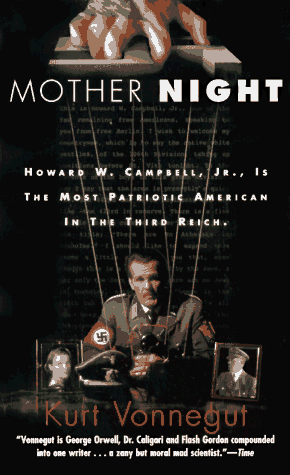



Recomendação 2: The Main Corpse (Culinary Mysteries (Paperback)) de Diane Mott Davidson



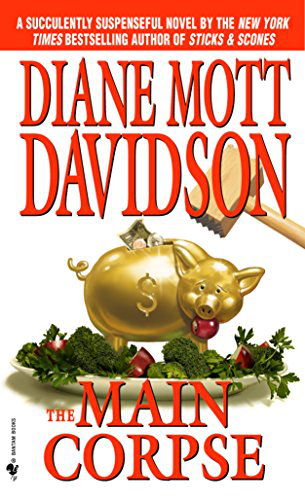



Recomendação 3: Dilbert: Seven Years Of Highly Defective People (P de Scott Adams



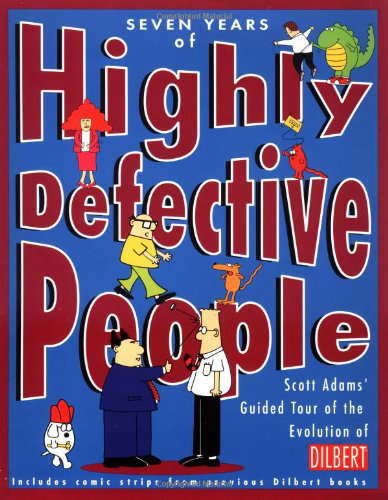

In [ ]:
for i in range(3):
  foto = data[data['ISBN'] == recommendation[i].get('ISBN')]['Image-URL-L'].unique()[0]
  with urllib.request.urlopen(foto) as url:
    with open('temp.jpg', 'wb') as f:
        f.write(url.read())
  img = Image.open('temp.jpg')
  print(f"Recomendação {i + 1}: {recommendation[i].get('Book-Title')} de {recommendation[i].get('Book-Author')}\n")
  display(img)
  print("\n")

In [ ]:
# Contar uma história sobre um usuário que gosta de x e Y livros e mostrar o resultado da recomendação
# Falar um pouco da Lib
# Discutir as aplicações
# Por fim o Front-end - SteamLit (ou Django)
# Pesquisar um pouco sobre o front-end em python - exemplos de uso
# Subir o notebook no Github e colocar na apresentação o link do github